<a id='Table of Contents'></a><h1>Table of Contents</h1>

- <a href='#introduction'>Introduction</a> 
- <a href='#imports'>Import and install required libraries</a>  
- <a href='#set_fitting'>Setting of fitting</a>  
- <a href='#run_fit'>Running the fit</a>  
- <a href='#results'>Showing the results</a>

(<a href='#Table of Contents'>Top</a>)<a id='introduction'></a><h2>Introduction</h2>

<div class="alert alert-block alert-info">
The objective of this notebook is to show how to use a combination of models from the QENS library <em>i.e.</em> <b>Lorentzian</b>  and <b>IsotropicRotationalDiffusion</b> models.
</div>

The data are a set of water data measured at IN5 (ILL).

**Reference:** J. Qvist, H. Schober and B. Halle, *J. Chem. Phys.* **134**, 144508 (2011)

(<a href='#Table of Contents'>Top</a>)<a id='imports'></a><h2> Import python modules for plotting, fitting... </h2>

In [2]:
# Imported required libraries
from __future__ import print_function
import sys
import os

# for interactive plots
import panel
panel.extension()
import panel.widgets as pnw

# the following two lines are to remove the warning about too many figures open simultaneously
import matplotlib
matplotlib.rcParams.update({'figure.max_open_warning': 0})

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# install bumps (if not already installed)
import pkgutil
if not pkgutil.find_loader("bumps"):
    !{sys.executable} -m pip install bumps
    
# check version of bumps installed
# Information message if installed version not recent enough
import bumps

from distutils.version import StrictVersion
if StrictVersion(bumps.__version__) <= StrictVersion('0.7.6'):
    print("""The version of bumps installed is not recent 
    enough to run the examples. 
    Please update bumps. The minimum version required is 0.7.8""")

 (<a href='#Table of Contents'>Top</a>)<a id='set_fitting'></a><h2>Setting of fitting </h2>
<h3> load data, prepare data, create fitting model and set initial guesses </h3>

In [4]:
# install QENSmodels (if not already installed)

if not pkgutil.find_loader("QENSmodels"):
    !{sys.executable} -m pip install git+https://github.com/QENSlibrary/QENSmodels#egg=QENSmodels

In [5]:
import h5py
import QENSmodels
import numpy as np
from scipy.integrate import simps
from bumps.names import *
from bumps.fitters import fit
from bumps.formatnum import format_uncertainty

path_to_data = './data/'

# Data
# Wavelength 5 Angstrom
f = h5py.File(path_to_data + 'H2O_293K_5A.hdf', 'r')
hw_5A = f['entry1']['data1']['X'][:]
q_5A = f['entry1']['data1']['Y'][:]
sqw_5A = np.transpose(f['entry1']['data1']['DATA'][:])
err_5A = np.transpose(f['entry1']['data1']['errors'][:])
f.close()

# Resolution
# Wavelength 5 Angstrom
f = h5py.File(path_to_data + 'V_273K_5A.hdf', 'r')
res_5A = np.transpose(f['entry1']['data1']['DATA'][:])
f.close()

# Force resolution function to have unit area
# Wavelength 5 Angstrom
for i in range(len(q_5A)):
    area = simps(res_5A[:, i], hw_5A)
    res_5A[:, i] /= area

# Fit range -1 to +1 meV
idx_5A = np.where(np.logical_and(hw_5A > -1.0, hw_5A < 1.0))

# Fitting model
def model_convol(x, q, scale=1, center=0, hwhm=1, radius=1, DR=1, resolution=None):
    model = QENSmodels.lorentzian(x, scale, center, hwhm) + QENSmodels.sqwIsotropicRotationalDiffusion(x, q, scale, center, radius, DR)
    return np.convolve(model, resolution/resolution.sum(), mode='same')

# Fit
M = []

for i in range(len(q_5A)):

    x = hw_5A[idx_5A]
    data = sqw_5A[idx_5A, i]
    error = err_5A[idx_5A, i]
    resol = res_5A[idx_5A, i]

    # Select only valid data (error = -1 for Q, w points not accessible)
    valid = np.where(error > 0.0)
    x = x[valid[1]]
    data = data[valid]
    error = error[valid]
    resol = resol[valid]

    # model
    Mq = Curve(model_convol, x, data, error, q=q_5A[i], scale=40,
               center=0.0, hwhm=0.1, radius=0.98, DR=0.5, resolution=resol)

    # Fitted parameters
    Mq.scale.range(0, 1e2)
    Mq.center.range(-0.1, 0.1)
    Mq.hwhm.range(0., 1)
    Mq.radius.range(0.9, 1.1)
    Mq.DR.range(0, 5)

    # Q-independent parameters
    if i == 0:
        Qhwhm = Mq.hwhm
        QR = Mq.radius
        QDR = Mq.DR
    else:
        Mq.hwhm = Qhwhm
        Mq.radius = QR
        Mq.DR = QDR

    M.append(Mq)

problem = FitProblem(M)

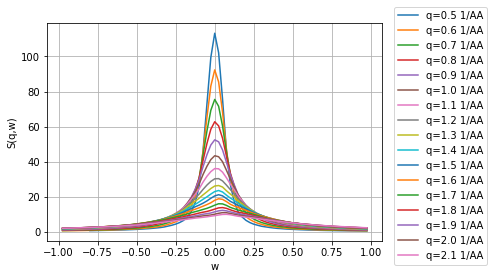

In [6]:
for i in range(len(q_5A)):

    x = hw_5A[idx_5A]
    data = sqw_5A[idx_5A, i]
    error = err_5A[idx_5A, i]
    resol = res_5A[idx_5A, i]

    # Select only valid data (error = -1 for Q, w points not accessible)
    valid = np.where(error > 0.0)
    x = x[valid[1]]
    data = data[valid]
    error = error[valid]
    resol = resol[valid]
    plt.grid()
    plt.xlabel("w")
    plt.ylabel("S(q,w)")
    plt.plot(x, data, label="q={:1.1f} 1/AA".format(q_5A[i]))
    
    plt.legend(bbox_to_anchor=(1.02,1.1), loc="upper left")
    
plt.show()

#### Choice of minimizers

In [7]:
options_dict={'Levenberg-Marquardt': "lm", 
             'Nelder-Mead Simplex': "amoeba", 
             'DREAM': "dream", 
             'Differential Evolution': "de", 
             'Quasi-Newton BFGS': "newton", 
             'Random Lines (experimental)': "rl", 
             'Particle Swarm (experimental)': "ps", 
             'Parallel Tempering (experimental)': "pt"}

w_choice_minimizer= pnw.Select(name='Minimizer:', options=list(options_dict.keys()), value='Levenberg-Marquardt')

w_choice_minimizer

Select(name='Minimizer:', options=OrderedDict([('Levenberg-M...]), value='Levenberg-Marquardt')

<h3> Setting for running bumps </h3>

In [8]:
# CHOICE OF MINIMIZER
chosen_minimizer = options_dict[w_choice_minimizer.value]

# NUMBER OF STEPS WHEN RUNNING THE FIT
steps = 100

Initial chisq 644147.207(31)


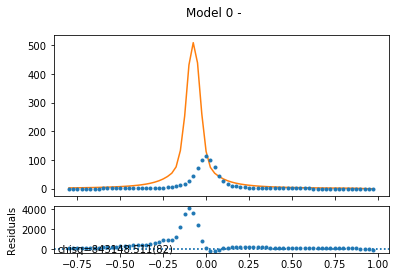

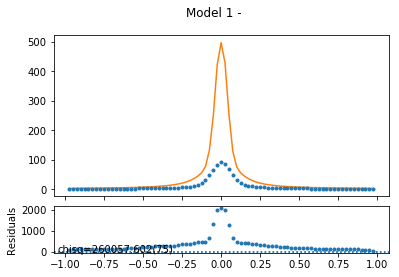

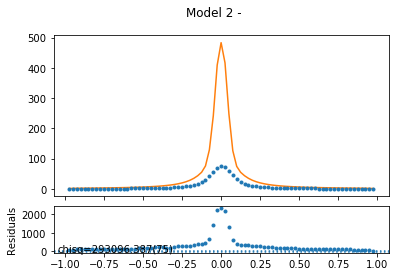

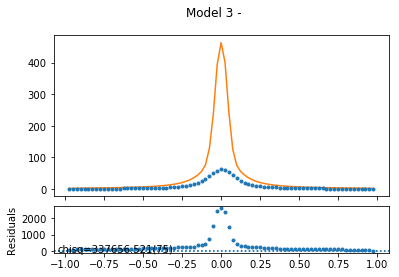

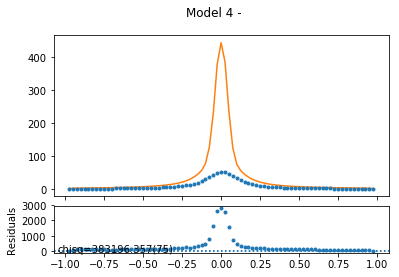

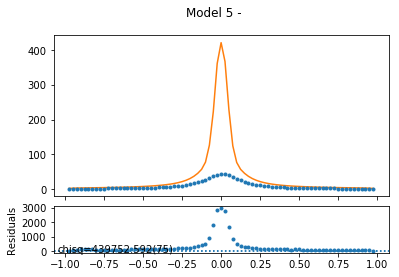

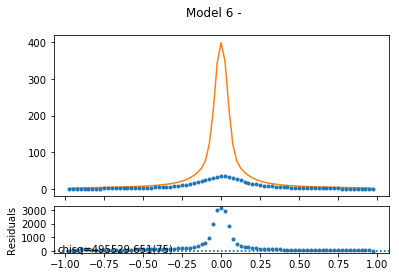

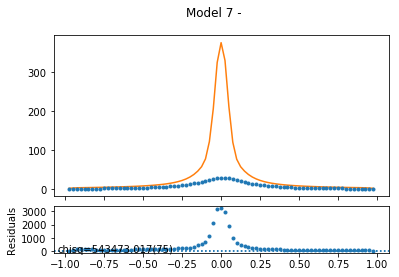

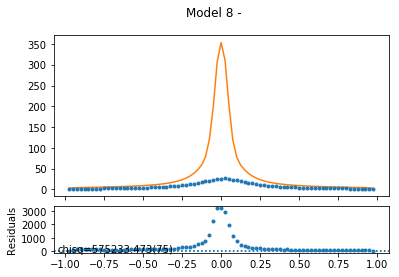

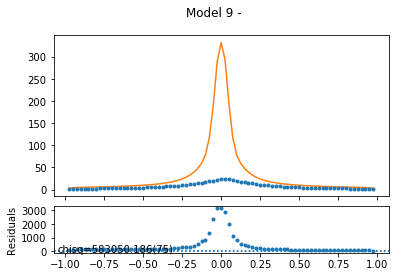

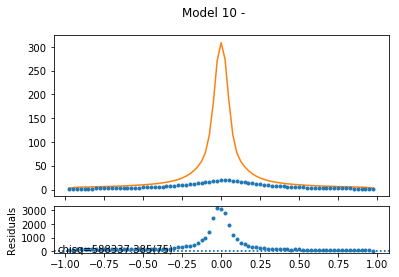

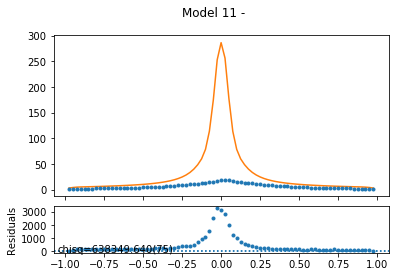

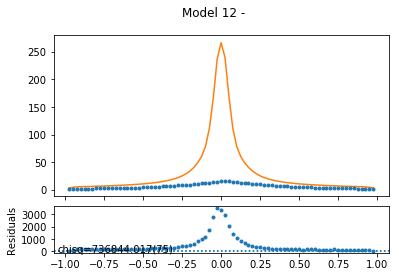

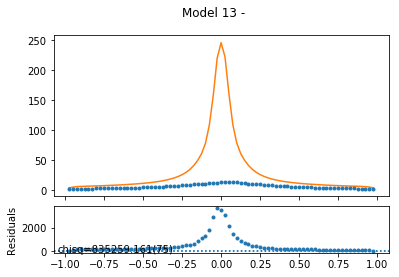

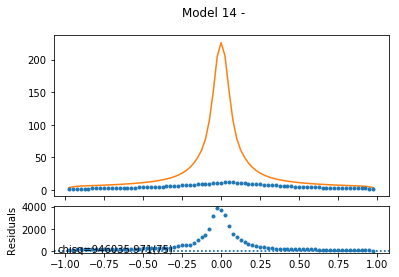

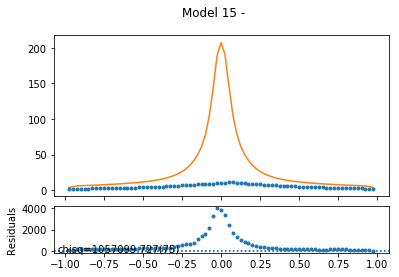

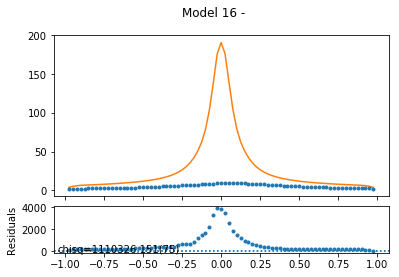

In [9]:
# Preview of the settings
print('Initial chisq', problem.chisq_str())
problem.plot()

(<a href='#Table of Contents'>Top</a>)<a id='run_fit'></a><h2>Running the fit</h2>

Run the fit using the *minimizer* defined above with a number of *steps* also specified above.

In [10]:
result = fit(problem, 
             method=chosen_minimizer, 
             steps=steps, verbose=True)

final chisq 6355.640(31)
=== Uncertainty est. from curvature: par    dx           dx/sqrt(chisq) ===
                                      DR 0.20882(62)     0.2088156(78)  
                                  center 0.03466(27)     0.0346597(34)  
                                    hwhm 0.12677(12)     0.1267705(15)  
                                  radius 1.0998998914(67) 1.099899891352(84)
                                   scale 7.0631(61)      7.063065(76)   
                                  center 0.00170(20)     0.0016952(25)  
                                   scale 9.9285(67)      9.928474(84)   
                                  center 0.00172(21)     0.0017248(27)  
                                   scale 9.5284(67)      9.528363(84)   
                                  center 0.00205(24)     0.0020540(30)  
                                   scale 9.0684(65)      9.068385(82)   
                                  center 0.00186(26)     0.0018579(33)  
                   

(<a href='#Table of Contents'>Top</a>)<a id='results'></a><h2>Showing the results </h2>

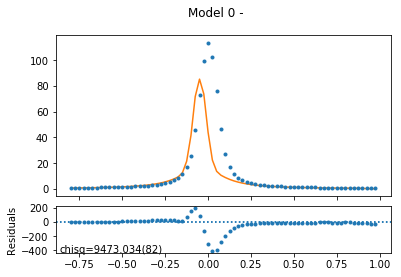

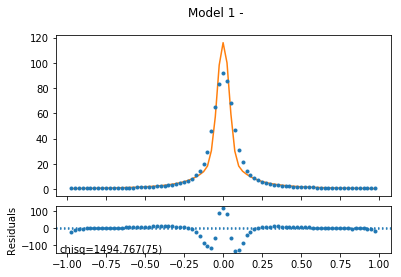

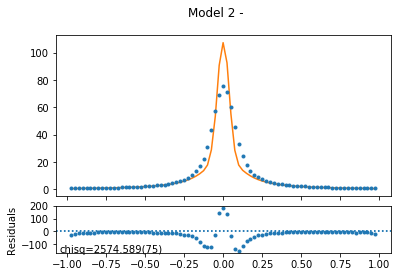

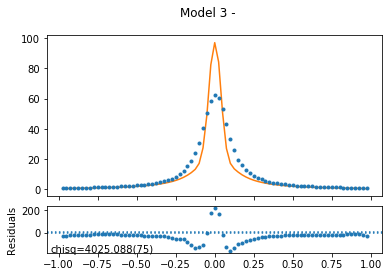

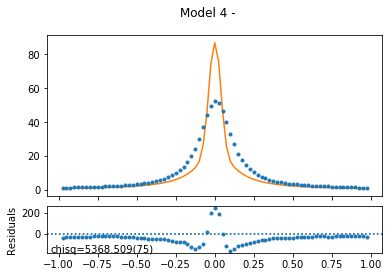

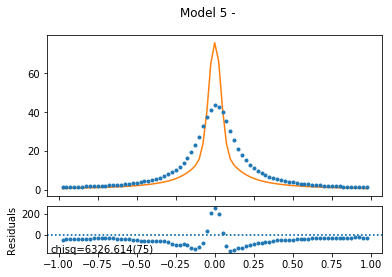

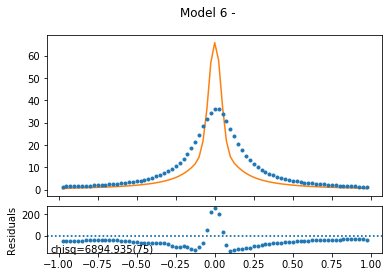

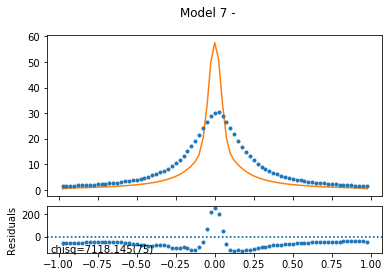

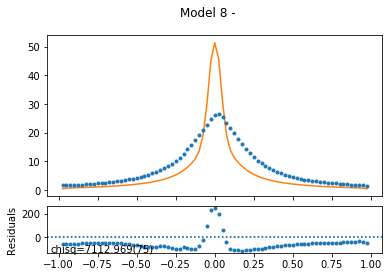

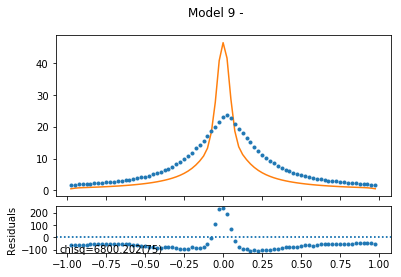

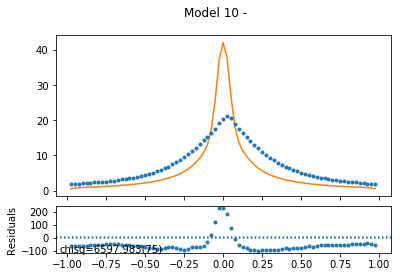

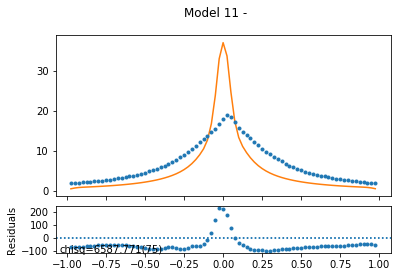

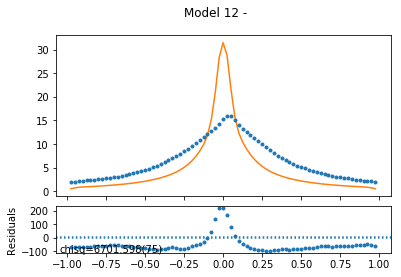

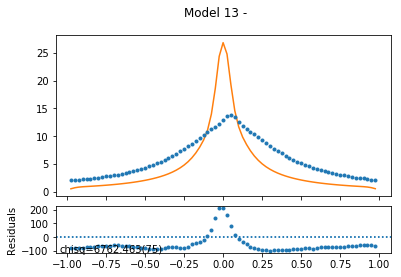

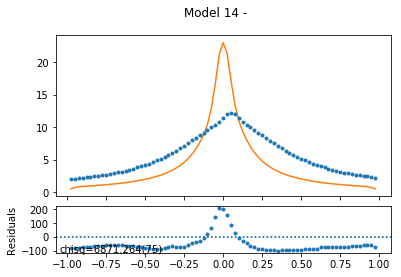

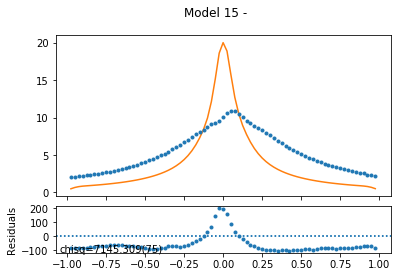

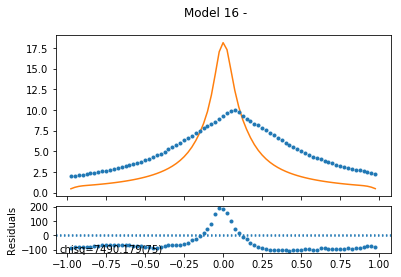

In [10]:
problem.plot()

In [11]:
# Print chi**2 and parameters' values after fit
print("final chisq", problem.chisq_str())
for k, v, dv in zip(problem.labels(), result.x, result.dx):
    print(k, ":", format_uncertainty(v, dv))

final chisq 6355.640(31)
DR : 0.20882(62)
center : 0.03466(27)
hwhm : 0.12677(12)
radius : 1.0998998914(67)
scale : 7.0631(61)
center : 0.00170(20)
scale : 9.9285(67)
center : 0.00172(21)
scale : 9.5284(67)
center : 0.00205(24)
scale : 9.0684(65)
center : 0.00186(26)
scale : 8.5818(63)
center : 0.00175(26)
scale : 7.9689(61)
center : 0.00182(28)
scale : 7.4031(60)
center : 0.00304(28)
scale : 6.9408(59)
center : 0.00310(27)
scale : 6.6976(58)
center : 0.00365(27)
scale : 6.5440(59)
center : 0.00448(26)
scale : 6.4580(59)
center : 0.00470(25)
scale : 6.2199(58)
center : 0.00436(25)
scale : 5.7765(56)
center : 0.00465(25)
scale : 5.3943(53)
center : 0.00463(25)
scale : 5.0998(52)
center : 0.00470(24)
scale : 4.8614(50)
center : 0.00455(23)
scale : 4.8172(49)
